# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

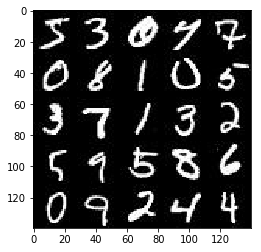

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

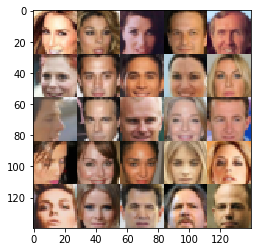

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
                                 
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x out_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    print_every =100
    show_every =500
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
#     print(input_real, input_z, lr)
    
#     saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(100, z_dim))
    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Steps {}...".format(steps+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)#sess, n_images, input_z, out_channel_dim, image_mode
                    
#         saver.save(sess, './checkpoints/generator.ckpt')

#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    
    return losses, samples                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Tensor("input_real:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("input_z:0", shape=(?, 100), dtype=float32) Tensor("learning_rate:0", dtype=float32)
Steps 26... Discriminator Loss: 0.0277... Generator Loss: 4.7521
Steps 51... Discriminator Loss: 0.1225... Generator Loss: 24.4625
Steps 76... Discriminator Loss: 2.9516... Generator Loss: 0.1945
Steps 101... Discriminator Loss: 0.0595... Generator Loss: 5.5380
Steps 126... Discriminator Loss: 0.1939... Generator Loss: 3.0454
Steps 151... Discriminator Loss: 0.2789... Generator Loss: 2.6858


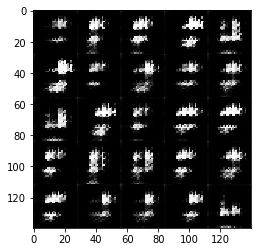

Steps 176... Discriminator Loss: 0.2843... Generator Loss: 2.7713
Steps 201... Discriminator Loss: 1.5287... Generator Loss: 13.6070
Steps 226... Discriminator Loss: 0.0314... Generator Loss: 4.1913
Steps 251... Discriminator Loss: 0.1497... Generator Loss: 2.5220
Steps 276... Discriminator Loss: 3.4200... Generator Loss: 14.2367
Steps 301... Discriminator Loss: 0.0301... Generator Loss: 5.8418


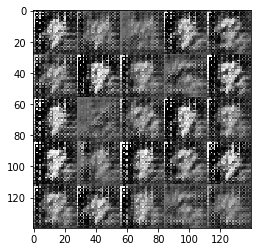

Steps 326... Discriminator Loss: 1.0594... Generator Loss: 0.7640
Steps 351... Discriminator Loss: 0.0738... Generator Loss: 4.7068
Steps 376... Discriminator Loss: 1.0157... Generator Loss: 2.1259
Steps 401... Discriminator Loss: 0.2190... Generator Loss: 2.9107
Steps 426... Discriminator Loss: 0.5465... Generator Loss: 1.3851
Steps 451... Discriminator Loss: 0.3712... Generator Loss: 2.4336


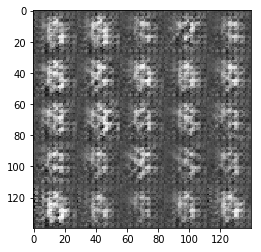

Steps 476... Discriminator Loss: 0.7099... Generator Loss: 1.1064
Steps 501... Discriminator Loss: 0.0503... Generator Loss: 6.2999
Steps 526... Discriminator Loss: 0.2507... Generator Loss: 2.1669
Steps 551... Discriminator Loss: 0.1065... Generator Loss: 4.7812
Steps 576... Discriminator Loss: 0.8954... Generator Loss: 0.8342
Steps 601... Discriminator Loss: 0.7205... Generator Loss: 0.8905


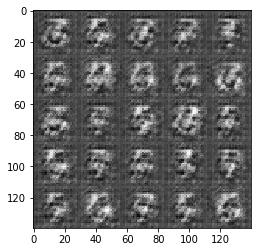

Steps 626... Discriminator Loss: 0.0450... Generator Loss: 4.4486
Steps 651... Discriminator Loss: 0.2983... Generator Loss: 2.2206
Steps 676... Discriminator Loss: 0.1599... Generator Loss: 2.9795
Steps 701... Discriminator Loss: 0.6370... Generator Loss: 1.2064
Steps 726... Discriminator Loss: 0.4252... Generator Loss: 2.4091
Steps 751... Discriminator Loss: 0.8004... Generator Loss: 0.7209


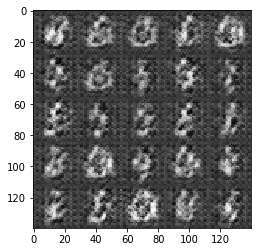

Steps 776... Discriminator Loss: 0.3885... Generator Loss: 3.7953
Steps 801... Discriminator Loss: 0.3403... Generator Loss: 2.8905
Steps 826... Discriminator Loss: 1.2411... Generator Loss: 0.4861
Steps 851... Discriminator Loss: 0.4919... Generator Loss: 1.6196
Steps 876... Discriminator Loss: 0.0416... Generator Loss: 4.0115
Steps 901... Discriminator Loss: 0.1459... Generator Loss: 2.8267


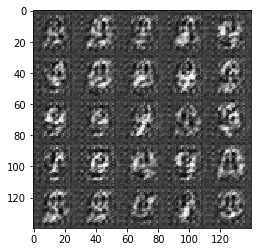

Steps 926... Discriminator Loss: 0.2863... Generator Loss: 2.5567
Steps 951... Discriminator Loss: 0.0502... Generator Loss: 4.1618
Steps 976... Discriminator Loss: 0.0828... Generator Loss: 3.1802
Steps 1001... Discriminator Loss: 0.0703... Generator Loss: 5.5465
Steps 1026... Discriminator Loss: 0.4534... Generator Loss: 1.5987
Steps 1051... Discriminator Loss: 0.2745... Generator Loss: 5.3211


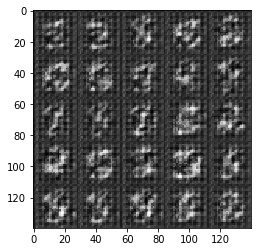

Steps 1076... Discriminator Loss: 0.0806... Generator Loss: 4.8222
Steps 1101... Discriminator Loss: 0.0520... Generator Loss: 3.7634
Steps 1126... Discriminator Loss: 0.2694... Generator Loss: 2.6206
Steps 1151... Discriminator Loss: 0.3800... Generator Loss: 1.4703
Steps 1176... Discriminator Loss: 0.1660... Generator Loss: 2.6580
Steps 1201... Discriminator Loss: 0.4585... Generator Loss: 1.3050


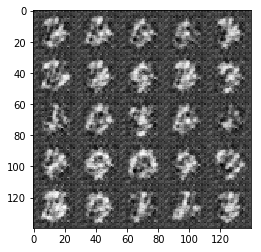

Steps 1226... Discriminator Loss: 0.0374... Generator Loss: 5.0499
Steps 1251... Discriminator Loss: 0.4509... Generator Loss: 3.0473
Steps 1276... Discriminator Loss: 0.5167... Generator Loss: 1.0844
Steps 1301... Discriminator Loss: 0.0523... Generator Loss: 5.7762
Steps 1326... Discriminator Loss: 0.9775... Generator Loss: 0.5906
Steps 1351... Discriminator Loss: 0.0376... Generator Loss: 4.7468


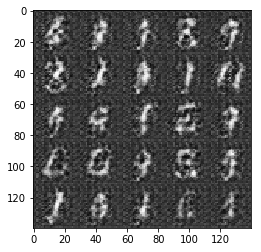

Steps 1376... Discriminator Loss: 0.0237... Generator Loss: 6.8542
Steps 1401... Discriminator Loss: 0.0040... Generator Loss: 8.1852
Steps 1426... Discriminator Loss: 0.5737... Generator Loss: 1.4167
Steps 1451... Discriminator Loss: 0.1388... Generator Loss: 2.4182
Steps 1476... Discriminator Loss: 0.1094... Generator Loss: 2.7879
Steps 1501... Discriminator Loss: 0.1422... Generator Loss: 2.6767


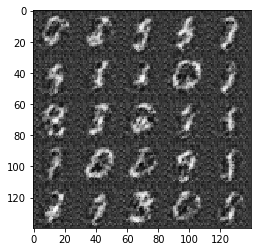

Steps 1526... Discriminator Loss: 0.1151... Generator Loss: 2.5106
Steps 1551... Discriminator Loss: 0.0579... Generator Loss: 3.4948
Steps 1576... Discriminator Loss: 0.7336... Generator Loss: 0.8504
Steps 1601... Discriminator Loss: 0.4601... Generator Loss: 4.6993
Steps 1626... Discriminator Loss: 0.2982... Generator Loss: 2.0740
Steps 1651... Discriminator Loss: 0.1187... Generator Loss: 2.7646


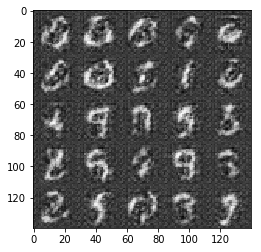

Steps 1676... Discriminator Loss: 0.0936... Generator Loss: 2.9117
Steps 1701... Discriminator Loss: 0.0904... Generator Loss: 3.4895
Steps 1726... Discriminator Loss: 0.0421... Generator Loss: 4.1968
Steps 1751... Discriminator Loss: 0.9306... Generator Loss: 1.0560
Steps 1776... Discriminator Loss: 0.2330... Generator Loss: 2.6131
Steps 1801... Discriminator Loss: 0.3117... Generator Loss: 1.6772


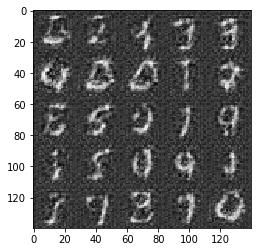

Steps 1826... Discriminator Loss: 0.2956... Generator Loss: 2.0686
Steps 1851... Discriminator Loss: 0.0203... Generator Loss: 4.5609
Steps 1876... Discriminator Loss: 0.0174... Generator Loss: 4.9253
Steps 1901... Discriminator Loss: 0.1123... Generator Loss: 2.8223
Steps 1926... Discriminator Loss: 0.0206... Generator Loss: 4.6187
Steps 1951... Discriminator Loss: 0.0883... Generator Loss: 2.8792


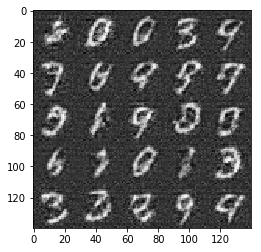

Steps 1976... Discriminator Loss: 0.0555... Generator Loss: 3.3466
Steps 2001... Discriminator Loss: 0.0233... Generator Loss: 4.6587
Steps 2026... Discriminator Loss: 0.6066... Generator Loss: 1.4973
Steps 2051... Discriminator Loss: 0.2095... Generator Loss: 3.7178
Steps 2076... Discriminator Loss: 0.1044... Generator Loss: 2.9046
Steps 2101... Discriminator Loss: 0.7404... Generator Loss: 1.0675


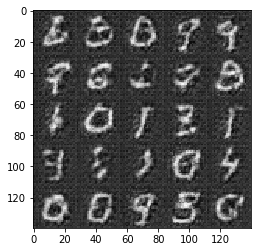

Steps 2126... Discriminator Loss: 0.3036... Generator Loss: 2.0924
Steps 2151... Discriminator Loss: 0.1361... Generator Loss: 2.6124
Steps 2176... Discriminator Loss: 0.0253... Generator Loss: 4.9486
Steps 2201... Discriminator Loss: 0.0631... Generator Loss: 4.2741
Steps 2226... Discriminator Loss: 0.2638... Generator Loss: 1.8267
Steps 2251... Discriminator Loss: 0.0660... Generator Loss: 3.3704


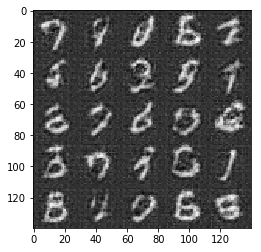

Steps 2276... Discriminator Loss: 0.5111... Generator Loss: 1.8771
Steps 2301... Discriminator Loss: 0.4124... Generator Loss: 5.6287
Steps 2326... Discriminator Loss: 0.4112... Generator Loss: 1.5313
Steps 2351... Discriminator Loss: 0.1845... Generator Loss: 2.4330
Steps 2376... Discriminator Loss: 0.2471... Generator Loss: 1.7377
Steps 2401... Discriminator Loss: 0.1621... Generator Loss: 2.3506


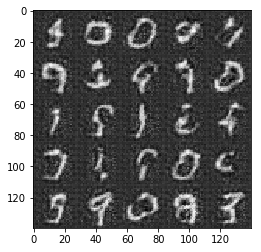

Steps 2426... Discriminator Loss: 0.9589... Generator Loss: 2.5895
Steps 2451... Discriminator Loss: 0.3770... Generator Loss: 2.2157
Steps 2476... Discriminator Loss: 0.2070... Generator Loss: 2.5086
Steps 2501... Discriminator Loss: 0.5197... Generator Loss: 1.2260
Steps 2526... Discriminator Loss: 0.0359... Generator Loss: 4.5398
Steps 2551... Discriminator Loss: 0.0982... Generator Loss: 2.8192


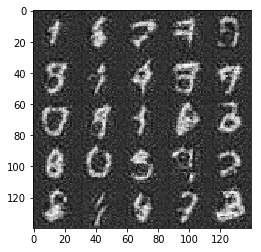

Steps 2576... Discriminator Loss: 0.0093... Generator Loss: 6.1648
Steps 2601... Discriminator Loss: 0.0124... Generator Loss: 5.8760
Steps 2626... Discriminator Loss: 0.0452... Generator Loss: 3.5533
Steps 2651... Discriminator Loss: 0.0086... Generator Loss: 5.5349
Steps 2676... Discriminator Loss: 0.0961... Generator Loss: 2.9137
Steps 2701... Discriminator Loss: 0.1713... Generator Loss: 2.9019


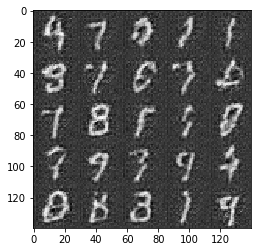

Steps 2726... Discriminator Loss: 0.2698... Generator Loss: 1.8624
Steps 2751... Discriminator Loss: 0.2104... Generator Loss: 4.7770
Steps 2776... Discriminator Loss: 0.7372... Generator Loss: 1.0047
Steps 2801... Discriminator Loss: 0.2433... Generator Loss: 1.8429
Steps 2826... Discriminator Loss: 0.5232... Generator Loss: 1.2802
Steps 2851... Discriminator Loss: 0.0165... Generator Loss: 4.9906


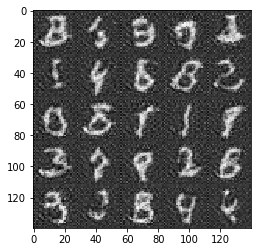

Steps 2876... Discriminator Loss: 0.0425... Generator Loss: 3.5434
Steps 2901... Discriminator Loss: 0.0171... Generator Loss: 5.0529
Steps 2926... Discriminator Loss: 0.1803... Generator Loss: 4.4509
Steps 2951... Discriminator Loss: 0.2138... Generator Loss: 2.4781
Steps 2976... Discriminator Loss: 0.4584... Generator Loss: 4.3676
Steps 3001... Discriminator Loss: 0.0657... Generator Loss: 3.8574


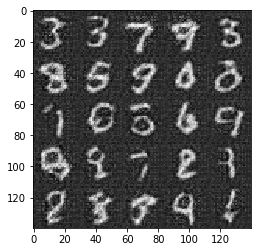

Steps 3026... Discriminator Loss: 0.2602... Generator Loss: 1.8768
Steps 3051... Discriminator Loss: 0.1105... Generator Loss: 3.2538
Steps 3076... Discriminator Loss: 0.0520... Generator Loss: 3.6619
Steps 3101... Discriminator Loss: 0.0323... Generator Loss: 4.2224
Steps 3126... Discriminator Loss: 0.0227... Generator Loss: 4.8517
Steps 3151... Discriminator Loss: 0.5752... Generator Loss: 1.1489


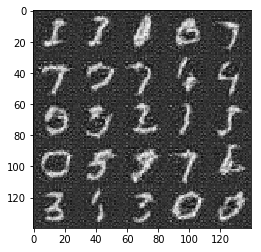

Steps 3176... Discriminator Loss: 0.1158... Generator Loss: 2.9503
Steps 3201... Discriminator Loss: 3.1279... Generator Loss: 0.3649
Steps 3226... Discriminator Loss: 0.3684... Generator Loss: 2.6461
Steps 3251... Discriminator Loss: 0.3588... Generator Loss: 2.8809
Steps 3276... Discriminator Loss: 0.1965... Generator Loss: 2.2526
Steps 3301... Discriminator Loss: 0.1620... Generator Loss: 2.5262


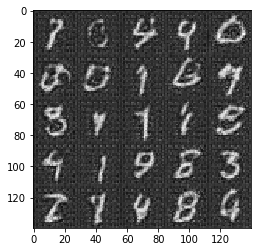

Steps 3326... Discriminator Loss: 0.0930... Generator Loss: 3.0174
Steps 3351... Discriminator Loss: 0.3670... Generator Loss: 1.6079
Steps 3376... Discriminator Loss: 0.0776... Generator Loss: 3.0612
Steps 3401... Discriminator Loss: 0.0177... Generator Loss: 4.7645
Steps 3426... Discriminator Loss: 0.0328... Generator Loss: 4.2092
Steps 3451... Discriminator Loss: 0.0082... Generator Loss: 5.9122


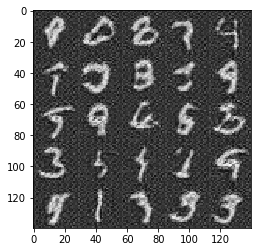

Steps 3476... Discriminator Loss: 0.0408... Generator Loss: 4.0341
Steps 3501... Discriminator Loss: 0.1818... Generator Loss: 2.2982
Steps 3526... Discriminator Loss: 0.0019... Generator Loss: 8.4976
Steps 3551... Discriminator Loss: 0.0233... Generator Loss: 4.5217
Steps 3576... Discriminator Loss: 0.2659... Generator Loss: 1.9983
Steps 3601... Discriminator Loss: 0.0040... Generator Loss: 6.6632


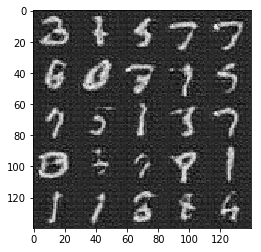

Steps 3626... Discriminator Loss: 0.0100... Generator Loss: 5.7557
Steps 3651... Discriminator Loss: 0.0274... Generator Loss: 4.1586
Steps 3676... Discriminator Loss: 0.0152... Generator Loss: 7.1134
Steps 3701... Discriminator Loss: 0.0445... Generator Loss: 3.9013
Steps 3726... Discriminator Loss: 1.5047... Generator Loss: 0.5560
Steps 3751... Discriminator Loss: 0.1404... Generator Loss: 3.3358


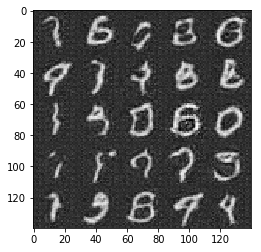

Steps 3776... Discriminator Loss: 0.1050... Generator Loss: 3.0858
Steps 3801... Discriminator Loss: 0.1440... Generator Loss: 4.6849
Steps 3826... Discriminator Loss: 0.9569... Generator Loss: 0.8080
Steps 3851... Discriminator Loss: 0.1426... Generator Loss: 5.4220
Steps 3876... Discriminator Loss: 2.2810... Generator Loss: 8.7826
Steps 3901... Discriminator Loss: 0.2340... Generator Loss: 2.8577


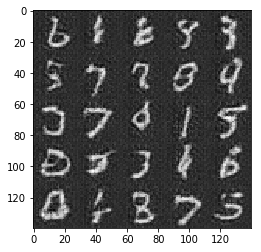

Steps 3926... Discriminator Loss: 0.2329... Generator Loss: 2.2604
Steps 3951... Discriminator Loss: 0.1713... Generator Loss: 5.1520
Steps 3976... Discriminator Loss: 0.5683... Generator Loss: 1.2088
Steps 4001... Discriminator Loss: 0.1716... Generator Loss: 2.7318
Steps 4026... Discriminator Loss: 1.2708... Generator Loss: 0.4703
Steps 4051... Discriminator Loss: 0.3343... Generator Loss: 1.8975


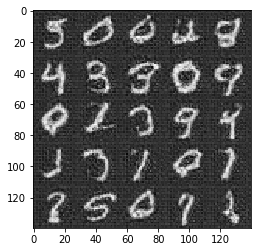

Steps 4076... Discriminator Loss: 0.0732... Generator Loss: 3.5336
Steps 4101... Discriminator Loss: 0.2325... Generator Loss: 1.8896
Steps 4126... Discriminator Loss: 0.9307... Generator Loss: 0.8062
Steps 4151... Discriminator Loss: 0.4699... Generator Loss: 1.4622
Steps 4176... Discriminator Loss: 0.0214... Generator Loss: 4.7644
Steps 4201... Discriminator Loss: 0.0194... Generator Loss: 5.0453


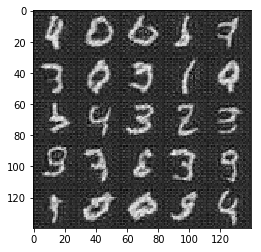

Steps 4226... Discriminator Loss: 0.1033... Generator Loss: 2.7876
Steps 4251... Discriminator Loss: 0.0447... Generator Loss: 3.7748
Steps 4276... Discriminator Loss: 0.7461... Generator Loss: 4.8770
Steps 4301... Discriminator Loss: 0.3993... Generator Loss: 3.0378
Steps 4326... Discriminator Loss: 0.6404... Generator Loss: 3.8011
Steps 4351... Discriminator Loss: 0.7695... Generator Loss: 1.0302


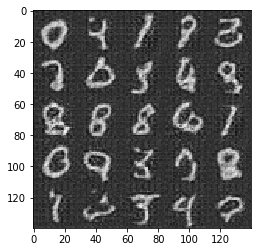

Steps 4376... Discriminator Loss: 1.6750... Generator Loss: 5.8208
Steps 4401... Discriminator Loss: 0.4875... Generator Loss: 1.5019
Steps 4426... Discriminator Loss: 1.3113... Generator Loss: 0.4485
Steps 4451... Discriminator Loss: 0.2321... Generator Loss: 2.0871
Steps 4476... Discriminator Loss: 0.2825... Generator Loss: 2.0940
Steps 4501... Discriminator Loss: 0.5094... Generator Loss: 1.2365


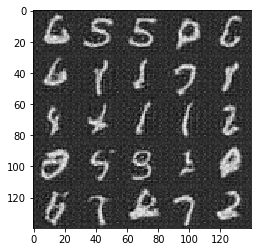

Steps 4526... Discriminator Loss: 0.2394... Generator Loss: 2.3836
Steps 4551... Discriminator Loss: 0.0218... Generator Loss: 4.5405
Steps 4576... Discriminator Loss: 0.1536... Generator Loss: 3.0061
Steps 4601... Discriminator Loss: 2.1510... Generator Loss: 0.2961
Steps 4626... Discriminator Loss: 0.5511... Generator Loss: 1.2404
Steps 4651... Discriminator Loss: 1.1379... Generator Loss: 0.9325


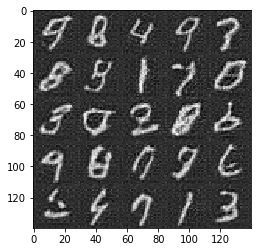

Steps 4676... Discriminator Loss: 0.5230... Generator Loss: 1.2506
Steps 4701... Discriminator Loss: 0.6092... Generator Loss: 1.1712
Steps 4726... Discriminator Loss: 0.0736... Generator Loss: 3.4924
Steps 4751... Discriminator Loss: 0.1767... Generator Loss: 2.3948
Steps 4776... Discriminator Loss: 0.0383... Generator Loss: 4.2157
Steps 4801... Discriminator Loss: 0.0134... Generator Loss: 5.3012


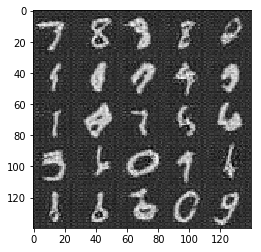

In [33]:
batch_size = 25
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Steps 101... Discriminator Loss: 3.6346... Generator Loss: 0.1169
Steps 201... Discriminator Loss: 1.3501... Generator Loss: 0.4239
Steps 301... Discriminator Loss: 0.9421... Generator Loss: 0.6109
Steps 401... Discriminator Loss: 0.5086... Generator Loss: 4.6869
Steps 501... Discriminator Loss: 0.6650... Generator Loss: 1.2674


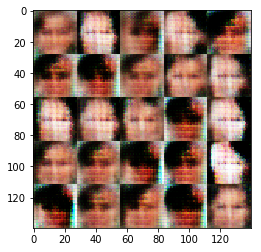

Steps 601... Discriminator Loss: 0.8237... Generator Loss: 1.4240
Steps 701... Discriminator Loss: 0.6498... Generator Loss: 1.7038
Steps 801... Discriminator Loss: 0.6122... Generator Loss: 1.3625
Steps 901... Discriminator Loss: 0.7881... Generator Loss: 1.2837
Steps 1001... Discriminator Loss: 0.6508... Generator Loss: 1.0096


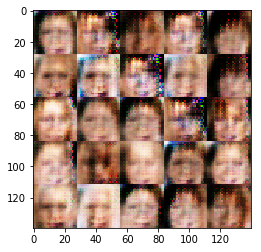

Steps 1101... Discriminator Loss: 1.7735... Generator Loss: 1.0182
Steps 1201... Discriminator Loss: 0.8334... Generator Loss: 1.1556
Steps 1301... Discriminator Loss: 0.7365... Generator Loss: 1.7250
Steps 1401... Discriminator Loss: 0.9873... Generator Loss: 1.1748
Steps 1501... Discriminator Loss: 1.0614... Generator Loss: 0.8769


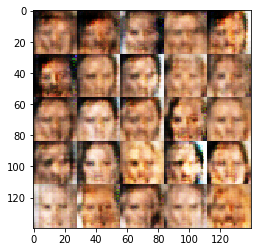

Steps 1601... Discriminator Loss: 0.7339... Generator Loss: 3.0682
Steps 1701... Discriminator Loss: 1.7819... Generator Loss: 0.2907
Steps 1801... Discriminator Loss: 1.1678... Generator Loss: 0.5942
Steps 1901... Discriminator Loss: 1.1636... Generator Loss: 1.0445
Steps 2001... Discriminator Loss: 1.2114... Generator Loss: 0.7156


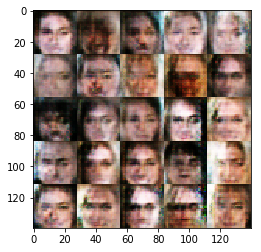

Steps 2101... Discriminator Loss: 0.9066... Generator Loss: 0.8639
Steps 2201... Discriminator Loss: 0.9469... Generator Loss: 1.8974
Steps 2301... Discriminator Loss: 0.7850... Generator Loss: 1.3311
Steps 2401... Discriminator Loss: 1.1072... Generator Loss: 0.9495
Steps 2501... Discriminator Loss: 1.0708... Generator Loss: 0.5965


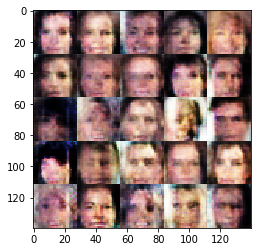

Steps 2601... Discriminator Loss: 0.3763... Generator Loss: 2.0434
Steps 2701... Discriminator Loss: 1.0700... Generator Loss: 1.0402
Steps 2801... Discriminator Loss: 0.9228... Generator Loss: 1.1795
Steps 2901... Discriminator Loss: 0.9397... Generator Loss: 0.8292
Steps 3001... Discriminator Loss: 1.0672... Generator Loss: 1.1726


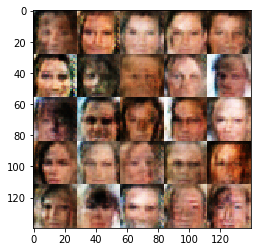

Steps 3101... Discriminator Loss: 1.1254... Generator Loss: 1.2630
Steps 3201... Discriminator Loss: 0.4169... Generator Loss: 1.9225
Steps 3301... Discriminator Loss: 1.0147... Generator Loss: 0.7287
Steps 3401... Discriminator Loss: 0.7520... Generator Loss: 0.9735
Steps 3501... Discriminator Loss: 1.7527... Generator Loss: 0.2261


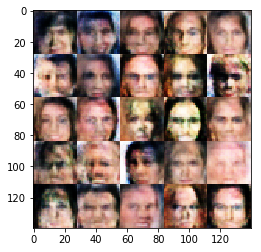

Steps 3601... Discriminator Loss: 1.0421... Generator Loss: 1.1448
Steps 3701... Discriminator Loss: 0.6550... Generator Loss: 1.7231
Steps 3801... Discriminator Loss: 0.7205... Generator Loss: 0.9301
Steps 3901... Discriminator Loss: 1.4410... Generator Loss: 0.4125
Steps 4001... Discriminator Loss: 0.9262... Generator Loss: 0.8566


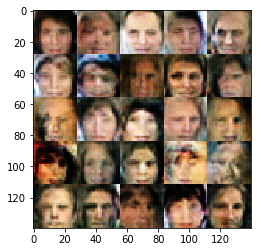

Steps 4101... Discriminator Loss: 0.9167... Generator Loss: 0.9766
Steps 4201... Discriminator Loss: 1.1176... Generator Loss: 0.6858
Steps 4301... Discriminator Loss: 0.5948... Generator Loss: 1.3263
Steps 4401... Discriminator Loss: 0.6891... Generator Loss: 1.0627
Steps 4501... Discriminator Loss: 1.7245... Generator Loss: 0.3266


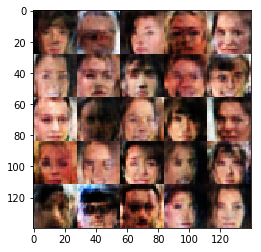

Steps 4601... Discriminator Loss: 1.3210... Generator Loss: 0.4340
Steps 4701... Discriminator Loss: 1.1524... Generator Loss: 0.5247
Steps 4801... Discriminator Loss: 1.1936... Generator Loss: 0.5496
Steps 4901... Discriminator Loss: 0.4145... Generator Loss: 1.8598
Steps 5001... Discriminator Loss: 0.7820... Generator Loss: 1.1215


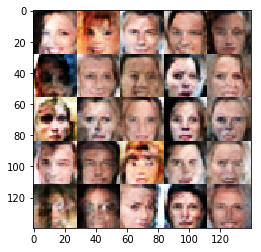

Steps 5101... Discriminator Loss: 1.0585... Generator Loss: 1.0486
Steps 5201... Discriminator Loss: 0.7144... Generator Loss: 0.9177
Steps 5301... Discriminator Loss: 1.0441... Generator Loss: 1.6926
Steps 5401... Discriminator Loss: 0.9651... Generator Loss: 1.1250
Steps 5501... Discriminator Loss: 1.2199... Generator Loss: 0.6873


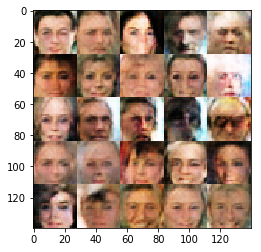

Steps 5601... Discriminator Loss: 0.9923... Generator Loss: 0.6345
Steps 5701... Discriminator Loss: 1.2256... Generator Loss: 0.5170
Steps 5801... Discriminator Loss: 0.8364... Generator Loss: 1.0742
Steps 5901... Discriminator Loss: 0.7027... Generator Loss: 1.2543
Steps 6001... Discriminator Loss: 1.0946... Generator Loss: 0.5983


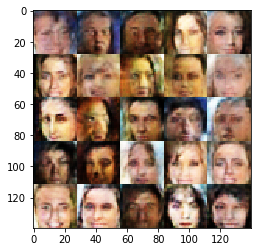

Steps 6101... Discriminator Loss: 0.7265... Generator Loss: 0.8812
Steps 6201... Discriminator Loss: 0.4332... Generator Loss: 1.7435
Steps 6301... Discriminator Loss: 0.9088... Generator Loss: 1.0254
Steps 6401... Discriminator Loss: 1.2835... Generator Loss: 0.5662
Steps 6501... Discriminator Loss: 1.0443... Generator Loss: 0.7585


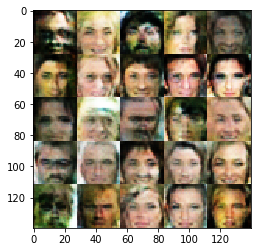

Steps 6601... Discriminator Loss: 1.3669... Generator Loss: 0.6391
Steps 6701... Discriminator Loss: 1.1186... Generator Loss: 0.7245
Steps 6801... Discriminator Loss: 1.0761... Generator Loss: 0.8210
Steps 6901... Discriminator Loss: 1.0379... Generator Loss: 0.7251
Steps 7001... Discriminator Loss: 0.5849... Generator Loss: 1.8044


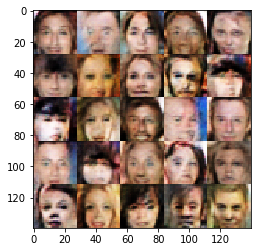

Steps 7101... Discriminator Loss: 1.1616... Generator Loss: 0.8599
Steps 7201... Discriminator Loss: 1.0842... Generator Loss: 0.7196
Steps 7301... Discriminator Loss: 1.1723... Generator Loss: 0.5162
Steps 7401... Discriminator Loss: 1.0336... Generator Loss: 0.8243
Steps 7501... Discriminator Loss: 0.4993... Generator Loss: 1.4752


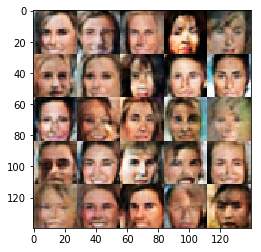

Steps 7601... Discriminator Loss: 0.8774... Generator Loss: 1.3995
Steps 7701... Discriminator Loss: 1.4902... Generator Loss: 0.3954
Steps 7801... Discriminator Loss: 0.7903... Generator Loss: 1.0012
Steps 7901... Discriminator Loss: 0.9356... Generator Loss: 0.6682
Steps 8001... Discriminator Loss: 0.5939... Generator Loss: 1.4640


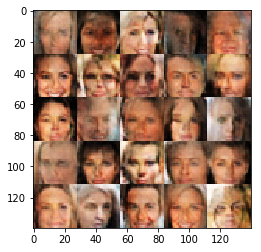

Steps 8101... Discriminator Loss: 0.9810... Generator Loss: 0.6944
Steps 8201... Discriminator Loss: 1.2496... Generator Loss: 0.5347
Steps 8301... Discriminator Loss: 1.4445... Generator Loss: 0.7213
Steps 8401... Discriminator Loss: 1.1126... Generator Loss: 0.7451
Steps 8501... Discriminator Loss: 0.9510... Generator Loss: 0.8545


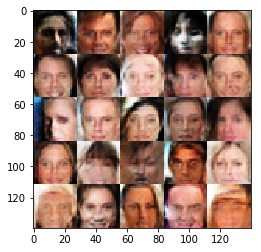

Steps 8601... Discriminator Loss: 1.1545... Generator Loss: 0.4769
Steps 8701... Discriminator Loss: 3.3565... Generator Loss: 0.0478
Steps 8801... Discriminator Loss: 1.0049... Generator Loss: 0.6880
Steps 8901... Discriminator Loss: 1.1685... Generator Loss: 0.5440
Steps 9001... Discriminator Loss: 0.9537... Generator Loss: 0.6054


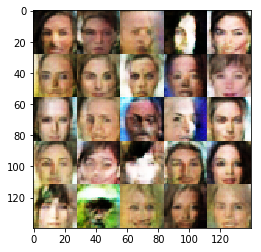

Steps 9101... Discriminator Loss: 1.2597... Generator Loss: 0.4254
Steps 9201... Discriminator Loss: 1.2689... Generator Loss: 0.6002
Steps 9301... Discriminator Loss: 1.0098... Generator Loss: 1.0886
Steps 9401... Discriminator Loss: 1.0778... Generator Loss: 0.5778
Steps 9501... Discriminator Loss: 1.0812... Generator Loss: 0.6746


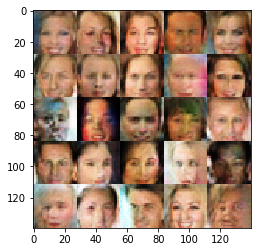

Steps 9601... Discriminator Loss: 0.0870... Generator Loss: 4.4368
Steps 9701... Discriminator Loss: 2.7448... Generator Loss: 0.0816
Steps 9801... Discriminator Loss: 0.7526... Generator Loss: 1.1786
Steps 9901... Discriminator Loss: 0.7394... Generator Loss: 1.2429
Steps 10001... Discriminator Loss: 0.3056... Generator Loss: 1.8473


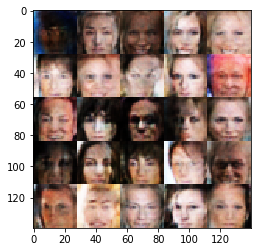

Steps 10101... Discriminator Loss: 1.8187... Generator Loss: 0.2658
Steps 10201... Discriminator Loss: 0.8220... Generator Loss: 0.8022
Steps 10301... Discriminator Loss: 1.0049... Generator Loss: 0.9539
Steps 10401... Discriminator Loss: 1.0624... Generator Loss: 0.6706
Steps 10501... Discriminator Loss: 1.2055... Generator Loss: 0.5372


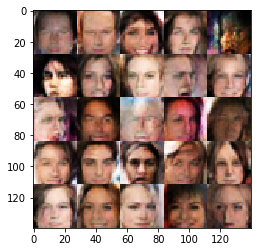

Steps 10601... Discriminator Loss: 1.0252... Generator Loss: 0.6572
Steps 10701... Discriminator Loss: 0.9259... Generator Loss: 1.0661
Steps 10801... Discriminator Loss: 1.3044... Generator Loss: 0.5309
Steps 10901... Discriminator Loss: 0.8892... Generator Loss: 0.9601
Steps 11001... Discriminator Loss: 0.9841... Generator Loss: 0.7610


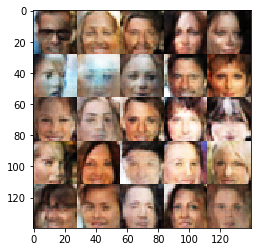

Steps 11101... Discriminator Loss: 0.7673... Generator Loss: 1.1759
Steps 11201... Discriminator Loss: 0.9729... Generator Loss: 0.8687
Steps 11301... Discriminator Loss: 0.9229... Generator Loss: 1.0133
Steps 11401... Discriminator Loss: 0.2002... Generator Loss: 3.1897
Steps 11501... Discriminator Loss: 0.8555... Generator Loss: 1.7805


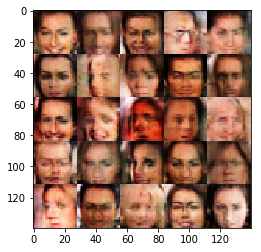

Steps 11601... Discriminator Loss: 1.2162... Generator Loss: 0.5620
Steps 11701... Discriminator Loss: 0.7845... Generator Loss: 2.7536
Steps 11801... Discriminator Loss: 1.1687... Generator Loss: 0.6955
Steps 11901... Discriminator Loss: 1.0406... Generator Loss: 0.8630
Steps 12001... Discriminator Loss: 1.0743... Generator Loss: 0.6710


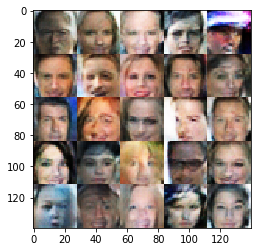

Steps 12101... Discriminator Loss: 0.9067... Generator Loss: 1.0426
Steps 12201... Discriminator Loss: 0.5223... Generator Loss: 1.2886
Steps 12301... Discriminator Loss: 1.0659... Generator Loss: 0.7121
Steps 12401... Discriminator Loss: 0.1159... Generator Loss: 2.5832
Steps 12501... Discriminator Loss: 0.9804... Generator Loss: 0.7055


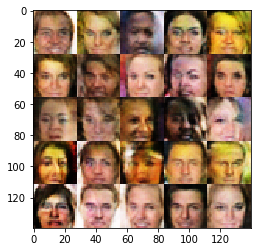

Steps 12601... Discriminator Loss: 1.1511... Generator Loss: 1.0081


In [19]:
batch_size = 16
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。